In [1]:
%pylab inline
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from writeit import *


Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
np.random.seed(555)
Nsamples =100
Summary = []

N = 20

fn = '../indata/randomwithN%d'%N
m32gal = 264.172


#generator = 'wilson' #sample complete graph to get an admissible tree
generator = 'spine'  #start with N-2 pipes comprising 'spine'; pick S random nodes between 1 and N1-1 to add spurs

    
for m in range(Nsamples):
    print "sample # %d\n"%m
    if generator=='wilson':
        print "generating random trees using Wilson's algorithm on complete graph, followed by filter for degree <3"
        Np = N-1
        Nn = N
        Ds = [0.1]*Np
        A2 = np.ones((N,N))-np.diag(np.ones(N),0)
        Gl2  = listRep(A2)
        nodeTypes = [4]*N
        while max(nodeTypes)>3 or nodeTypes[0]!=1:
            conn2 = randomTreeWithRoot(0,Gl2)
            nl = conn2[:,0]
            nr = conn2[:,1]
            nodeTypes = [sum(len(find(nl==k))+len(find(nr==k))) for k in range(N)]
        IN = nodeTypes.index(1)
    
    if generator =='spine':
        S = 5
        N1 = N-N/4
        N2 = S
        Np = N1+N2-1
        Nn = N1+N2
        print "generating random trees starting with spine of %d nodes and adding %d branches"%(N1,N2)
        conn2 = np.ndarray((N1+N2-1,2),int)
        for k in range(N1-1):
            conn2[k,:] = (k,k+1)
            avail = [i for i in range(1,N1-1)]
        for k in range(N2):
            where = np.random.randint(0,N1-2-k)
            spur = avail.pop(where)
            conn2[k+N1-1,0]=spur
            conn2[k+N1-1,1] = N1+k
        nl = conn2[:,0]
        nr = conn2[:,1]
        nodeTypes = [sum(len(find(nl==k))+len(find(nr==k))) for k in range(Nn)]
        IN =0
        Ds = [0.1]*(N1-1)+[.1]*N2

    Ls = [20]*Np
    print Ls
    Ns = [int(max(Ls))]*Np
    #Ns = [int(Ls[j]) for j in range(Np)]
    Mrs = [0.007]*Np
    print Mrs[0]
    h0 = max(np.random.normal(.5,.5),0)*Ds[0]/2.
    h0s = [h0]*Np
    print h0
    q0s = [0.00]*Np
    T = 10.
    Mi = 10
    Nt = 2*N+3
    Tmax = Nt*T

    a = 100
    dx = [Ls[i]/Ns[i] for i in range(Np)] 

    tol = Ds[0]
    print nodeTypes
    fn = '../indata/randomwithN%d'%N
    jt = nodeTypes
    
    xs = np.random.rand(Nn)
    ys = np.random.rand(Nn)
    #reflect everything
    bt = [1]*Nn
    r = [1]*Nn
    r[IN]=0
    bv = [0.]*Nn
    bv[IN]=0.0087
    elevs = [0]*Nn
    elevs[IN] +=.1*Ls[0]
    #elevs = [e+np.random.normal(0,elevs[0]/8.) for e in elevs]
    print elevs
    print a
    M = int(T*a/(max(dx)*.8))


    (fi, fc) = writePipes(fn,conn2, xs,ys, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
    arrive = np.zeros((Np,Ns[0]))
    maxH = np.zeros(Np)
    Vsys = np.pi*Ds[0]**2/4.*sum(Ls)
    print "system volume is %f gal "%(Vsys*m32gal)
    Hs =np.zeros((M/Mi*Nt,sum(Ns)))
    n0=PyNetwork(fi,fc,1)
    
    print n0.Ns

    dt = T/float(M)
    #Q0 = 0.0087*np.ones(M+1)
    #n0.setbVal(0,Q0)
    V0 = n0.getTotalVolume()
    Vin =  0
    Ttot = 0
    count = 0
    t0 = time.clock()
    dH = []
    while count<Nt and Vin<Vsys:
        n0.runForwardProblem(dt)
        Vin  = n0.getTotalVolume()-V0
        for k in range(0,Np):
            for K in range(0,Ns[k]):
                Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
                #Hs[count*M/Mi:(count+1)*(M/Mi),K+Ns[0]*k] =Ht[1::Mi] 
                maxH[k] = max(max(Ht),maxH[k])
                where = find(Ht>tol)
                if len(where)>0 and arrive[k,K]==0.:
                    arrive[k,K] = Ttot+dt*(where[0])
        dH.append(mean([n0.getAveGradH(i) for i in range(M+1)]))
        count+=1
        Ttot +=T
        print "T = %f, Volume = %f"%(Ttot, m32gal*Vin)
        n0.reset()
    tf = time.clock()
    print "inflow volume is %f gallons"%(Vin*m32gal)
    print "simulation time is %f s"%Ttot
    print "wall clock time is %f s"%(tf-t0)
    print dH
    print maxH
    print "max arrival time is %f"%(arrive.max())
    data = {}
    data['conn']=conn2
    data['h0'] = h0
    data['max_arrive_t'] = [max(arrive[k,:]) for k in range(Np)]
    data['min_arrive_t'] = [min(arrive[k,:]) for k in range(Np)]
    data['last_arrive_t'] = arrive.max()
    data['nodeTypes'] = nodeTypes
    data['mean_dH'] = mean(dH)
    data['max_H'] = maxH
    data['Vin'] = Vin

    Summary.append(data)
    

    
    

sample # 0

generating random trees starting with spine of 15 nodes and adding 5 branches
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
0.007
0.0494356547256
[1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]
[2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100
../indata/fakeinp.inp
system volume is 788.424774 gal 
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
T = 10.000000, Volume = 42.184143
T = 20.000000, Volume = 88.053771
T = 30.000000, Volume = 103.526033
T = 40.000000, Volume = 116.197747
T = 50.000000, Volume = 139.182323
T = 60.000000, Volume = 162.165431
T = 70.000000, Volume = 185.148541
T = 80.000000, Volume = 208.131744
T = 90.000000, Volume = 231.115031
T = 100.000000, Volume = 254.098323
T = 110.000000, Volume = 277.081614
T = 120.000000, Volume = 300.064990
T = 130.000000, Volume = 323.048457
T = 140.000000, Volume = 346.031982
T = 150.000000, Volume = 369.015617
T = 160.000000, Volume = 391.999282
T = 

In [3]:

print "max(T_a)  mean(max(H))  mean(dH)   h0"
for k in range(len(Summary)):
    print"%3.2f    %2.6f     %3.6f   %.2f   "%(Summary[k]['last_arrive_t'],\
                                         mean(Summary[k]['max_H']),Summary[k]['mean_dH'],Summary[k]['h0'])

max(T_a)  mean(max(H))  mean(dH)   h0
170.50    346.863872     4.807157   0.05   
252.50    160.722862     18.021282   0.02   
176.74    307.954558     3.037677   0.04   
319.78    17.075823     4.515690   0.00   
301.22    90.771161     7.860118   0.01   
268.35    165.556732     4.808421   0.02   
317.94    13.900459     4.407532   0.00   
149.98    372.554278     4.211097   0.05   
307.60    75.073641     7.056789   0.01   
180.63    305.420249     2.991046   0.04   
109.26    414.026065     2.810214   0.06   
117.52    396.487101     5.418475   0.06   
145.83    362.053180     2.803082   0.05   
244.30    173.924576     3.875924   0.03   
270.78    141.788010     4.472230   0.02   
279.08    71.274070     8.329786   0.01   
300.55    72.117969     4.568465   0.01   
274.47    132.903263     4.337163   0.02   
243.30    181.394112     10.524972   0.03   
116.22    409.566158     2.653745   0.06   
279.38    15.997195     4.499157   0.00   
299.93    19.433865     4.714620   0.00   


5


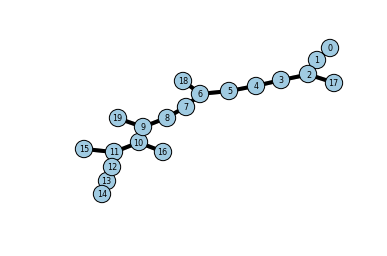

In [4]:
which = 0
conns = Summary[which]['conn']
import networkx as nx
from networkx import graphviz_layout
G=nx.Graph()
Dpos = {}
for k in range(len(Summary[which]['nodeTypes'])-1):
    G.add_edge('%d'%conns[k,0],'%d'%conns[k,1])
pos=nx.spring_layout(G) # positions for all nodes
pos=nx.graphviz_layout(G,root=0)
# nodes
nx.draw_networkx_nodes(G,pos,node_size=300,node_color = '#A0CBE2', iter=100)
# edges
nx.draw_networkx_edges(G,pos,width=4,edge_cmap=plt.cm.coolwarm)
nx.draw_networkx_edges(G,pos,width=4.0,alpha=0.3)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
print Summary[0]['nodeTypes'].count(3)


In [5]:
import pickle

In [8]:
#generator = 'wilson'
name = "output_data/random_networks/summary_N%d_samples%d_%s_random_h0"%(N,Nsamples,generator)
#name = "output_data/random_networks/summary_N%d_samples%d_%s"%(N,Nsamples,generator)
f1 = open(name+'.pkl','wb')
pickle.dump(Summary,f1)
f1.close()

In [61]:
with open(name+'.txt','w') as f2:
    f2.write("max(T_a)  mean(max(H))  mean(dH)   %junction1s %junction2s   %junction3s\n")
    for k in range(len(Summary)):
        c = [Summary[k]['nodeTypes'].count(j) for j in range(1,4)]
        f2.write("%3.2f    %2.6f     %3.6f   %.2f          %.2f               %.2f\n"%(Summary[k]['last_arrive_t'],\
                                         mean(Summary[k]['max_H']),Summary[k]['mean_dH'],c[0]/float(N), c[1]/float(N),c[2]/float(N)))

In [63]:
name = "output_data/random_networks/summary_N%d_samples%d_%s_variable_spurs"%(N,Nsamples,generator)
print name

output_data/random_networks/summary_N20_samples100_spine_variable_spurs


[1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 1, 3, 2, 1, 3, 1]


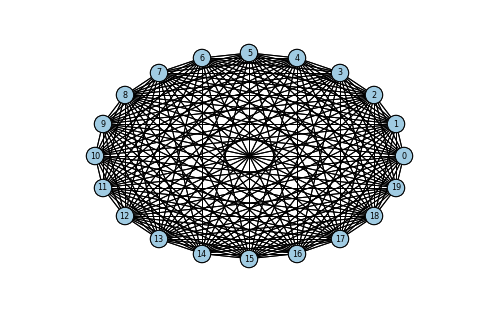

In [146]:
G = nx.Graph(A2)
#pos=nx.spectral_layout(G) # positions for all nodes
# nodes
nx.draw_circular(G,node_size=300,node_color = '#A0CBE2')
pos=nx.circular_layout(G) # positions for all nodes
# nodes
nx.draw_networkx_nodes(G,pos,node_size=300,node_color = '#A0CBE2', iter=300)
# edges
nx.draw_networkx_edges(G,pos,width=1,edge_cmap=plt.cm.coolwarm)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
print Summary[0]['nodeTypes']

In [52]:
print Summary[1]

{'mean_dH': 58.896549754611179, 'Vin': 2.199450277223604, 'max_H': array([ 113.01333586,   11.38314344,   11.61568269,   11.80709035,
         12.06557722,   12.20831332,   12.3132504 ,   12.31435275,
         12.39691881,   12.40120213,   12.36643296,   12.33271988,
         12.37653675,   12.42818228]), 'last_arrive_t': 190.648, 'conn': array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14]]), 'max_arrive_t': [190.44, 42.335999999999999, 35.287999999999997, 46.68, 59.456000000000003, 70.656000000000006, 84.584000000000003, 97.951999999999998, 113.84, 131.40799999999999, 147.816, 163.82400000000001, 183.304, 190.648], 'nodeTypes': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], 'min_arrive_t': [44.280000000000001, 26.192, 25.84, 35.335999999999999, 46.712000000000003, 59.496000000000002, 70.671999999999997,